In [93]:
from transformers import FlaubertModel

from custom_dataloading import load_encoded_dataset
from torch.utils.data import DataLoader
import torchvision
import wandb
import torch
from torch import nn, optim, utils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

In [94]:
from safetensors.torch import save_file

In [95]:
tensors = torch.load("models/vae_7.pth")
save_file(tensors, 'models/safetensors/vae_7.safetensors')

In [96]:
latent_dim = 7

In [97]:
from vae_scott import ResNetVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
vae = ResNetVAE(latent_dim=latent_dim, spatial=False).to(device)
vae.load_state_dict(torch.load(f'models/vae_{latent_dim}.pth', map_location=device))
vae.eval()

ResNetVAE(
  (encoder): ResNetVAEEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (levels): ModuleList(
      (0): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, ker

In [98]:
from custom_dataloading import load_encoded_dataset

train_ds, test_ds = load_encoded_dataset(f'data/ResNetVAEEncoder_ld{latent_dim}/MNIST/')
batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [99]:
train_dl.dataset.data.shape

(60000, 7)

In [73]:
for data, target in train_dl:
    data.to(device)
    sampled_x = torch.randn_like(data)
    break

In [100]:
from flow_helpers import integrate_path, rk4_step

In [101]:
model = FlatVelocityNet(latent_dim)

In [102]:
model.load_state_dict(torch.load(f'models/flow_{latent_dim}.pth', map_location=device))

<All keys matched successfully>

In [103]:

@torch.no_grad()
def spatial_integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    model_dtype = next(model.parameters()).dtype

    y = initial_points.to(device=device, dtype=model_dtype).clone()

    ts = torch.linspace(0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)

    def f(y_, t_scalar):
        B = y_.shape[0]
        # Make a per-batch t vector; float dtype usually expected
        t_vec = torch.full((B,), float(t_scalar), device=y_.device, dtype=y_.dtype)

        if y_.dim() == 2:  # [B, D] non-spatial
            return model(y_, t_vec)  # -> [B, D]
        elif y_.dim() == 3:  # [B, H, W] -> assume C=1
            out = model(y_.unsqueeze(1), t_vec)  # -> [B, 1, H, W]
            return out.squeeze(1)  # -> [B, H, W]
        elif y_.dim() == 4:  # [B, C, H, W]
            return model(y_, t_vec)  # -> [B, C, H, W]
        else:
            raise ValueError(f"Unsupported state shape {y_.shape}")

    if save_trajectories: trajectories = [y.detach().clone()]

    for i in range(len(ts) - 1):
        t, dt = ts[i], ts[i + 1] - ts[i]
        y = step_fn(f, y, t, dt)
        if save_trajectories: trajectories.append(y.detach().clone())
    if save_trajectories: return y, torch.stack(trajectories).cpu()
    return y

In [84]:
sampled_x.shape

torch.Size([128, 7])

In [85]:
import torch

@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100, save_trajectories=False, warp_fn=None):
    """
    Unified integrator for both:
      - non-spatial: [B, D]
      - spatial: [B, C, H, W]  (or [B, H, W], treated as C=1)

    Assumes model forward is: model(z, t_vec) -> same shape as z (or [B,1,H,W] for [B,H,W]).
    """
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype

    y = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()

    ts = torch.linspace(0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn:
        ts = warp_fn(ts)


    t_cache = {"tensor": None, "B": None}  # use to cache tensor shape

    def adapted_model(y_, t_scalar):
        B = y_.shape[0]

        if t_cache["tensor"] is None or t_cache["B"] != B or t_cache["tensor"].device != y_.device:
            t_cache["tensor"] = torch.empty((B, 1), device=y_.device, dtype=y_.dtype)
            t_cache["B"] = B
        t_vec = t_cache["tensor"]
        t_vec.fill_(float(t_scalar))  # in-place fill
        if y_.dim() == 2:                      # [B, D]
            return model(y_, t_vec)            # -> [B, D]
        elif y_.dim() == 3:                    # [B, H, W]  (assume C=1)
            out = model(y_.unsqueeze(1), t_vec)  # -> [B, 1, H, W]
            return out.squeeze(1)                 # -> [B, H, W]
        elif y_.dim() == 4:                    # [B, C, H, W]
            return model(y_, t_vec)            # -> [B, C, H, W]
        else:
            raise ValueError(f"Unsupported state shape {tuple(y_.shape)}")

    if save_trajectories: trajectories = [y.detach().clone()]

    for i in range(len(ts) - 1):
        t, dt = ts[i], ts[i + 1] - ts[i]
        y = step_fn(adapted_model, y, t, dt)
        if save_trajectories: trajectories.append(y.detach().clone())
    if save_trajectories: return y, torch.stack(trajectories).cpu()

    return y

In [87]:
sampled_x.shape

torch.Size([128, 7])

In [ ]:
sampled_x = torch.randn_like(data)
t = torch.rand(sampled_x.size(0), 1, device=device)
integrate_path(model, sampled_x, n_steps=10, step_fn=rk4_step)

In [104]:
import torch.nn as nn
import torch.nn.functional as F

class FlatVelocityNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)
    
    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

class SimpleFlowModel(nn.Module):
    def __init__(self, latent_dim=3, n_hidden=32, n_layers=3, act=nn.LeakyReLU):
        super(SimpleFlowModel, self).__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(
            nn.Linear(latent_dim+1, n_hidden), act(),
            *[nn.Sequential(nn.Linear(n_hidden, n_hidden), act()) for _ in range(n_layers-1)],
            nn.Linear(n_hidden, latent_dim),)

    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        return self.layers(x)

In [34]:
import torch, numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

@torch.no_grad()
def plot_latent_tsne3d(
    model,
    dataloader,                # e.g. test_dl
    n_samples=2000,
    pca_dim=50,                # set None to skip PCA
    perplexity=30,
    learning_rate=200,
    random_state=42,           # reproducible t-SNE
    device=None,
    title="Latent Space (t-SNE 3D)"
):
    was_training = model.training
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    Zs, Ys = [], []
    total = 0
    for xb, yb in dataloader:
        if total >= n_samples: break
        xb = xb.to(device)
        enc_out = model.encoder(xb)
        if isinstance(enc_out, (tuple, list)) and len(enc_out) >= 2:
            mu, logvar = enc_out[:2]
            z = mu
        else:
            z = enc_out  # AE case

        if z.dim() > 2:                    # [B,C,H,W] -> [B, C*H*W]
            z = z.view(z.size(0), -1)

        Zs.append(z.detach().cpu())
        Ys.append(yb.detach().cpu())
        total += z.size(0)

    if not Zs:
        print("No data found—check dataloader / n_samples.")
        if was_training: model.train()
        return

    Z = torch.cat(Zs, 0)[:n_samples].numpy()
    Y = torch.cat(Ys, 0)[:n_samples].numpy()

    # optional PCA pre-step (commonly recommended before t-SNE)
    if pca_dim is not None and Z.shape[1] > pca_dim:
        Z = PCA(n_components=pca_dim, random_state=random_state).fit_transform(Z)

    Z_tsne = TSNE(
        n_components=3,
        perplexity=perplexity,
        learning_rate=learning_rate,
        init="pca",
        random_state=random_state,
        n_iter=1000,
        verbose=0
    ).fit_transform(Z)

    fig = px.scatter_3d(
        x=Z_tsne[:,0], y=Z_tsne[:,1], z=Z_tsne[:,2],
        color=Y.astype(str),
        opacity=0.75, template="plotly_dark"
    )
    fig.update_traces(marker=dict(size=3, line=dict(width=0)))
    fig.update_layout(
        width=900, height=650,
        scene=dict(xaxis_title="tSNE-1", yaxis_title="tSNE-2", zaxis_title="tSNE-3",
                   aspectmode="cube"),
        title=title
    )
    fig.show()

    if was_training: model.train()
    return fig

In [105]:
flow_model = FlatVelocityNet(latent_dim)
flow_model.to(device)

FlatVelocityNet(
  (fc_in): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=7, bias=True)
)

In [106]:
@torch.no_grad()
def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return current_points + velocity * dt 
@torch.no_grad()
def rk4_step(f, y, t, dt):
    # f: callable (y, t) -> dy/dt  (aka model forward haha)
    k1 = f(y, t)
    k2 = f(y + 0.5*dt*k1, t + 0.5*dt)
    k3 = f(y + 0.5*dt*k2, t + 0.5*dt)
    k4 = f(y + dt*k3,     t + dt)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    
@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    current_points = initial_points.clone()
    ts =  torch.linspace(0,1,n_steps).to(device)
    if warp_fn: ts = warp_fn(ts)
    if save_trajectories: trajectories = [current_points]    
    for i in range(len(ts)-1):
        current_points = step_fn(model, current_points, ts[i], ts[i+1]-ts[i])
        if save_trajectories: trajectories.append(current_points)
    if save_trajectories: return current_points, torch.stack(trajectories).cpu()
    return current_points 

@torch.no_grad()
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle. 
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s<0 or s>1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t 
    if dt:                           # warped time-step requested; use derivative
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s) 
    return tw

In [107]:
project = 'spatial_vae_conv_testing'
def train_flow_model(model, train_loader, test_loader, name='flow_model', epochs=20, lr=0.001, warp_fn=None):
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    global_step = 1
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, _) in enumerate(pbar):
            optimizer.zero_grad()
            
            # Get data and create a sample from it to calc movement
            target_x = data.to(device)
            sampled_x = torch.randn_like(target_x)
            
            t  = torch.rand(sampled_x.size(0), 1, device=device)
            if warp_fn: t = warp_fn(t)

            interpolated_x = sampled_x * (1 - t) + target_x * t
            line_directions = target_x - sampled_x
            
            drift = model(interpolated_x, t)
            loss = criterion(drift, line_directions)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()
                
            wandb.log({
                "step": global_step,
                "train_loss": loss.item(),
                "cos_sim": cos_sim.item(),
                "drift": drift.norm(dim=1).mean().item(),
            })
            global_step += 1

    return model

In [38]:
project = 'spatial_vae_conv_testing'
def train_reflow_model(model, train_loader, test_loader, pretrained_model=None, name='flow_model', epochs=20, lr=0.001, new_points_every=1, warp_fn=None):
    # Move to device
    device = next(model.parameters()).device
    model.to(device)
    if pretrained_model is not None:
        pretrained_model.to(device)
        pretrained_model.eval()
    
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    global_step = 1
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, _) in enumerate(pbar):
            optimizer.zero_grad()
            
            target_x = data.to(device)

            if global_step % new_points_every == 0:
                sampled_x = torch.randn_like(target_x)
                if pretrained_model:   # ReFlow
                    target_x = integrate_path(pretrained_model, sampled_x, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)
            
            t  = torch.rand(sampled_x.size(0), 1, device=device)
            if warp_fn: t = warp_fn(t)

            interpolated_x = sampled_x * (1 - t) + target_x * t
            line_directions = target_x - sampled_x
            
            drift = model(interpolated_x, t)
            loss = criterion(drift, line_directions)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()
                
            wandb.log({
                "step": global_step,
                "train_loss": loss.item(),
                "cos_sim": cos_sim.item(),
                "drift": drift.norm(dim=1).mean().item(),
            })
            global_step += 1

    return model

In [108]:
train_flow_model(flow_model, train_dl, test_dl, name=f'flow:)_{latent_dim}')

cos_sim,▁███████████████████████████████████████
drift,▁▂▅▆▆▇▇█▇█▇█▇██▇███▇▇▇▇▇▇▇▇█▇▇█▇▇█▇▇▇██▇
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cos_sim,0.99811
drift,5.77149
step,9380
train_loss,0.02371


Epoch 20/20: 100%|██████████| 469/469 [00:01<00:00, 331.48it/s]


FlatVelocityNet(
  (fc_in): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=7, bias=True)
)

In [12]:
train_flow_model(flow_model, train_dl, test_dl, name='flow_vae_7')

wandb: Currently logged in as: marcocassar (marcocassar-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 20/20: 100%|██████████| 469/469 [00:01<00:00, 277.99it/s]


FlatVelocityNet(
  (fc_in): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=7, bias=True)
)

In [43]:
# torch.save(simple_flow.state_dict(), f"models/simple_flow_{latent_dim}.pth")
torch.save(new_model.state_dict(), f"models/simple_reflow_{latent_dim}.pth")

In [42]:
pretrained_flow_model = simple_flow
new_model = SimpleFlowModel(latent_dim)
new_model.to(device)
train_reflow_model(new_model, train_dl, test_dl,pretrained_flow_model, name=f'simple_reflow_{latent_dim}')

cos_sim,▁▇█▆▇▇▇▇▇▇▇▇▇▇██▇▇█▇▇▆▇▇▇██▇▇▇▇▇▇▆▇▇▇▇▇▇
drift,▁▃▄▆▄▅▆▅▆▄▅▅▄▆▅▆▅▆▅█▆▅▇▆▆▆▆▇▇▇▅▅▅▅▆▆▆▆▆▆
step,▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▃▃▃▃▃▃▃▂▃▂▂▂▂▂▃▃▂▃▁▂▃▃▂▂▁▂▂▂▂▃▂▁▂▂▂▁▂▂▂
cos_sim,0.79415
drift,6.60859
step,9380
train_loss,3.08127


Epoch 20/20: 100%|██████████| 469/469 [00:08<00:00, 56.61it/s]


SimpleFlowModel(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [109]:
class MarcosModel(nn.Module):
    def __init__(self, vae, flow_model, latent_dim=3):
        super().__init__()

        #--- REQUIRED INFO:
        self.info = { 
            'team': 'Marco',  # REPLACE with your team name. This will be public
            'names': 'Marco', # or single name. This will be kept private
        }
        self.latent_dim = latent_dim
        self.device = 'mps'

        #--- TEMP
        self.vae = vae
        self.flow_model = flow_model

        # keep support for full auto-initialization:
        # self.load_vae()
        # self.load_flow_model()

        # Integrate later
    
    def generate_samples(self, n_samples:int, n_steps=100) -> torch.Tensor:
            z0 = torch.randn(n_samples, self.latent_dim, device=self.device)
            z1 = integrate_path(self.flow_model, z0, n_steps=n_steps, step_fn=rk4_step)
            gen_xhat = F.sigmoid(self.decode(z1).view(-1, 28, 28))
            return gen_xhat

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        # if your vae has linear layers, flatten first
        # if your vae has conv layers, comment out next line
        # images = images.view(images.size(0), -1)  
        with torch.no_grad():
            z = self.vae.encoder(images.to(self.device))
            mu = z[:, :self.latent_dim]  # return only first half (mu)
            return mu
    
    def decode(self, latents: torch.Tensor) -> torch.Tensor:
        return self.vae.decoder(latents)

    def to(self, device):
        self.device = device 
        self.vae.to(self.device)
        self.flow_model.to(self.device)
        return self 

In [110]:
import matplotlib.pyplot as plt

def plot_generated(gen_xhat, nrow=5):
    gen_xhat = gen_xhat.detach().cpu()

    # assume shape (N, 28, 28)
    n_samples = gen_xhat.size(0)
    ncol = nrow
    nrow = (n_samples + ncol - 1) // ncol

    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*2, nrow*2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n_samples:
            ax.imshow(gen_xhat[i], cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [111]:
test_model = MarcosModel(vae, flow_model, latent_dim=7)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 7]

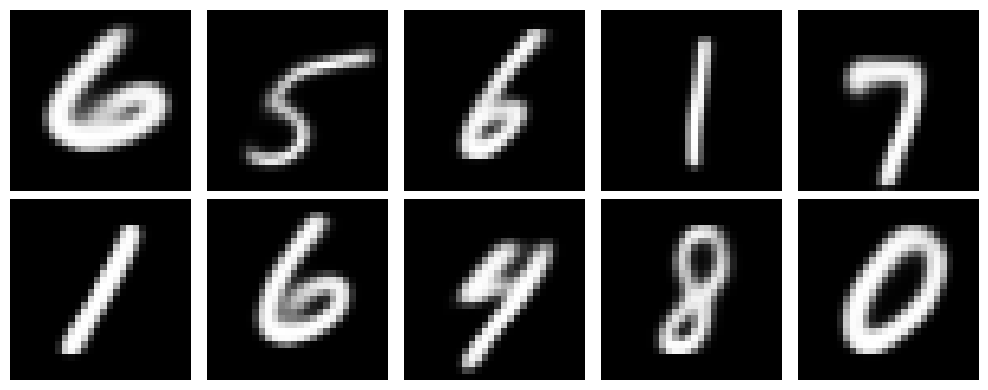

In [112]:
plot_generated(test_model.generate_samples(10,8))

In [273]:
new_model_worker = MarcosModel(vae, new_model, latent_dim=latent_dim)
model_worker = MarcosModel(vae, pretrained_flow_model, latent_dim=latent_dim)

Old Samples


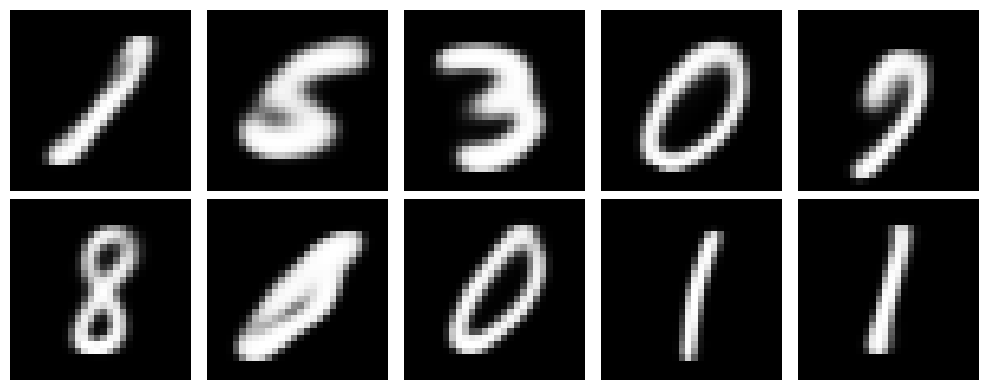

New Samples


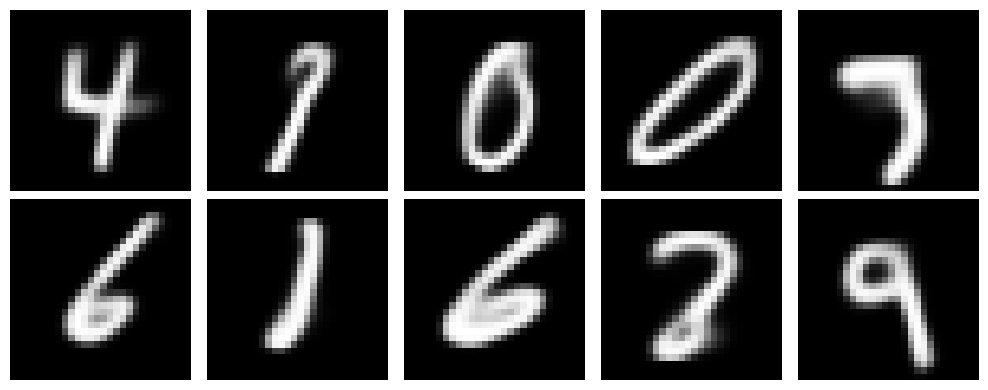

In [275]:
new_samples = new_model_worker.generate_samples(10, 8)
prev_samples = model_worker.generate_samples(10, 8)

print("Old Samples")
plot_generated(prev_samples)

print("New Samples")
plot_generated(new_samples)

In [99]:
# class SimpleCNNFlowModel(nn.Module):
#     def __init__(self, latent_dim=3, n_hidden=32, n_layers=3, act=nn.LeakyReLU):
#         super(SimpleCNNFlowModel, self).__init__()
#         self.latent_dim = latent_dim
# Later try to do spatial        

In [8]:
class SimpleFlowModel(nn.Module):
    def __init__(self, latent_dim=3, n_hidden=32, n_layers=3, act=nn.LeakyReLU):
        super(SimpleFlowModel, self).__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(
            nn.Linear(latent_dim+1, n_hidden), act(),
            *[nn.Sequential(nn.Linear(n_hidden, n_hidden), act()) for _ in range(n_layers-1)],
            nn.Linear(n_hidden, latent_dim),)

    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        return self.layers(x)

In [308]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
from tqdm import tqdm

@torch.no_grad()
def create_latent_flow_animation(
    flow_model,
    latent_dataloader,  # Dataloader with (latents, labels) where latents is [B, D]
    n_samples=500,
    n_frames=50,
    model2=None,  # Optional second flow model for comparison
    titles=None,
    save_file=None,
    figsize=(5, 5),
    device='mps',
    reducer='tsne',  # 'pca' or 'tsne'
    perplexity=30
):
    """
    Create animation showing how latents flow through your flow model.
    Shows initial noise distribution flowing to target latent distribution.
    Uses consistent 2D projection (fit once, apply to all trajectories).
    
    Args:
        flow_model: Your trained flow model (takes x, t)
        latent_dataloader: DataLoader yielding (latents, labels) 
                          where latents shape is [B, D] (e.g., [B, 7])
        n_samples: Number of points to animate
        n_frames: Number of animation frames
        model2: Optional second flow model for comparison
        save_file: If provided, saves animation as MP4
        reducer: 'pca' or 'tsne' for dimensionality reduction
        perplexity: Perplexity for t-SNE (ignored if reducer='pca')
    """
    flow_model.eval()
    if model2 is not None:
        model2.eval()
    
    # 1) Extract latents from dataloader
    print("Loading latents from dataloader...")
    latents, labels = [], []
    for z_batch, y_batch in latent_dataloader:
        if len(latents) * z_batch.size(0) >= n_samples:
            remaining = n_samples - sum(z.size(0) for z in latents)
            if remaining <= 0:
                break
            z_batch = z_batch[:remaining]
            y_batch = y_batch[:remaining]
        
        latents.append(z_batch)
        labels.append(y_batch)
    
    latents = torch.cat(latents, 0).to(device)
    labels = torch.cat(labels, 0).cpu().numpy()
    
    print(f"Got {len(latents)} latent points with dimension {latents.shape[1]}")
    
    latent_dim = latents.shape[1]
    
    # 2) Generate trajectories in full latent space FIRST
    print("Computing trajectories with RK4...")
    
    # Start from noise in full latent space
    noise_full = torch.randn_like(latents)
    noise_full = noise_full * latents.std(dim=0, keepdim=True) + latents.mean(dim=0, keepdim=True)
    
    _, trajectories_full = integrate_path(
        flow_model, noise_full, 
        step_fn=rk4_step, 
        n_steps=n_frames,
        save_trajectories=True,
        warp_fn=warp_time
    )
    
    trajectories_full2 = None
    if model2 is not None:
        print("Computing trajectories for model 2...")
        _, trajectories_full2 = integrate_path(
            model2, noise_full,
            step_fn=rk4_step,
            n_steps=n_frames, 
            save_trajectories=True,
            warp_fn=warp_time
        )
    
    # 3) Fit reducer on ALL data (target latents + all trajectory points) for consistency
    if latent_dim > 2:
        print(f"Fitting {reducer.upper()} on all data for consistent projection...")
        
        # Combine target latents + all trajectory frames for fitting
        all_data = [latents.cpu().numpy()]
        for i in range(len(trajectories_full)):
            all_data.append(trajectories_full[i].cpu().numpy())
        if trajectories_full2 is not None:
            for i in range(len(trajectories_full2)):
                all_data.append(trajectories_full2[i].cpu().numpy())
        
        all_data = np.vstack(all_data)
        print(f"Fitting on {len(all_data)} total points...")
        
        if reducer.lower() == 'tsne':
            from sklearn.manifold import TSNE
            perplexity = min(perplexity, len(all_data) // 4)
            projection = TSNE(
                n_components=2, 
                perplexity=perplexity,
                learning_rate=200,
                random_state=42,
                n_jobs=-1
            )
            all_data_2d = projection.fit_transform(all_data)
            print("t-SNE fitting complete")
        else:
            from sklearn.decomposition import PCA
            projection = PCA(n_components=2)
            all_data_2d = projection.fit_transform(all_data)
            print(f"PCA explained variance: {projection.explained_variance_ratio_.sum():.2%}")
        
        # Split back into original components
        n_latents = len(latents)
        n_per_frame = len(trajectories_full[0])
        
        latents_2d = torch.tensor(all_data_2d[:n_latents], dtype=torch.float32, device=device)
        
        trajectories = []
        offset = n_latents
        for i in range(len(trajectories_full)):
            traj_2d = all_data_2d[offset:offset+n_per_frame]
            trajectories.append(torch.tensor(traj_2d, dtype=torch.float32, device=device))
            offset += n_per_frame
        
        trajectories2 = None
        if trajectories_full2 is not None:
            trajectories2 = []
            for i in range(len(trajectories_full2)):
                traj_2d = all_data_2d[offset:offset+n_per_frame]
                trajectories2.append(torch.tensor(traj_2d, dtype=torch.float32, device=device))
                offset += n_per_frame
        
        # Get noise_2d for plot range
        noise_2d = trajectories[0]
        
    else:
        # Already 2D, no projection needed
        latents_2d = latents
        noise_2d = noise_full.to(device)
        trajectories = [trajectories_full[i].to(device) for i in range(len(trajectories_full))]
        trajectories2 = None
        if trajectories_full2 is not None:
            trajectories2 = [trajectories_full2[i].to(device) for i in range(len(trajectories_full2))]
    
    # 4) Setup plot
    if titles is None:
        titles = ['Flow Model']
        if model2:
            titles.append('Model 2')
    
    n_plots = 1 + (model2 is not None)
    if model2:
        figsize = (figsize[0] * 2, figsize[1])
    
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    plt.close()
    
    # Determine plot ranges (fixed across all frames)
    all_points = torch.cat([noise_2d, latents_2d], dim=0).cpu().numpy()
    max_range = max(abs(all_points).max(), 3.0)
    
    # Setup axes
    for ax in axes:
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
    
    # 5) Create animation
    print("Generating animation frames...")
    
    # Compute warped timesteps for display
    ts = torch.linspace(0, 1, n_frames + 1)
    ts_warped = warp_time(ts).numpy()
    
    # Progress bar for animation rendering
    pbar = tqdm(total=n_frames, desc="Rendering frames", unit="frame")
    
    def init():
        for ax in axes:
            ax.clear()
            ax.set_xlim(-max_range, max_range)
            ax.set_ylim(-max_range, max_range)
        return []
    
    def animate(frame):
        pbar.update(1)  # Update progress bar
        t_display = ts_warped[frame]
        
        for i, ax in enumerate(axes):
            ax.clear()
            ax.set_xlim(-max_range, max_range)
            ax.set_ylim(-max_range, max_range)
            ax.set_aspect('equal')
            
            reducer_label = reducer.upper() if latent_dim > 2 else ""
            title = f"{titles[i]} (t={t_display:.2f})"
            if reducer_label:
                title += f" [{reducer_label}]"
            ax.set_title(title)
            
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'right', 'bottom', 'left']:
                ax.spines[spine].set_visible(False)
            
            # Plot target latents (faint, always visible)
            ax.scatter(latents_2d[:, 0].cpu(), latents_2d[:, 1].cpu(), 
                      c='lightgray', alpha=0.3, s=8, label='Target', zorder=1)
            
            # Plot flowing particles (brighter, on top)
            if i == 0:
                current = trajectories[frame]
                ax.scatter(current[:, 0].cpu(), current[:, 1].cpu(), 
                          c=labels, cmap='tab10', alpha=0.7, s=15, 
                          edgecolors='white', linewidth=0.3, zorder=2)
            else:
                current = trajectories2[frame]
                ax.scatter(current[:, 0].cpu(), current[:, 1].cpu(), 
                          c=labels, cmap='tab10', alpha=0.7, s=15,
                          edgecolors='white', linewidth=0.3, zorder=2)
        
        return []
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n_frames, interval=50, blit=False)
    
    if save_file:
        print(f"Saving animation to {save_file}...")
        anim.save(save_file, writer='ffmpeg', fps=20)
        pbar.close()
        print("Done!")
        return HTML(f"""<center><video height="400" controls loop>
                    <source src="{save_file}" type="video/mp4">
                    Your browser does not support the video tag.</video></center>""")
    else:
        pbar.close()
        rc('animation', html='jshtml')
        return HTML(anim.to_jshtml())

In [310]:
create_latent_flow_animation(
    flow_model=pretrained_flow_model,
    latent_dataloader=train_dl,
    model2=new_model,
    n_samples=500,
    n_frames=500,
    titles=['Original Flow', 'Reflowed Model'],
    save_file='flow_comparison.mp4',
    device='mps'
)

Loading latents from dataloader...
Got 512 latent points with dimension 7
Computing trajectories with RK4...
Computing trajectories for model 2...
Fitting TSNE on all data for consistent projection...
Fitting on 512512 total points...
t-SNE fitting complete
Generating animation frames...
Saving animation to flow_comparison.mp4...
Done!
